<a href="https://colab.research.google.com/github/hideOncodee/CNN-IC2023/blob/main/IC2023_AlexNet_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Original.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
data_dir = '/content/Original'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    batch_size=64,
    image_size=(257, 257),
    validation_split=0.3,
    subset='training',
    seed=123,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=64,
    image_size=(257, 257),
    shuffle=True,
    validation_split=0.3,
    subset='validation',
    seed=123,
)

Found 1219 files belonging to 2 classes.
Using 854 files for training.
Found 1219 files belonging to 2 classes.
Using 365 files for validation.


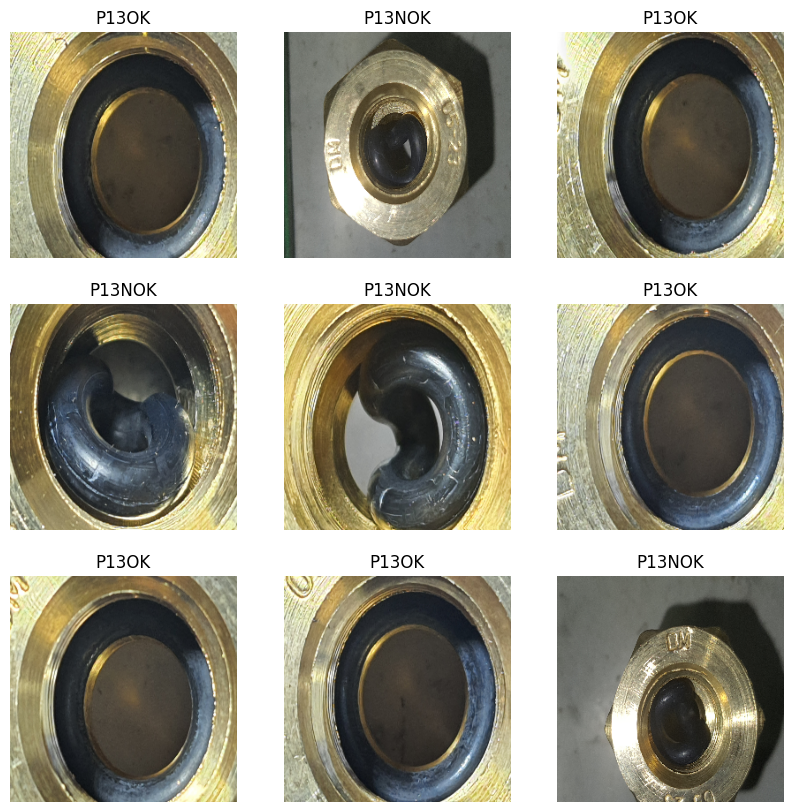

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical',
                               input_shape=(257, 257, 3)),
    tf.keras.layers.RandomRotation(0.3),
])

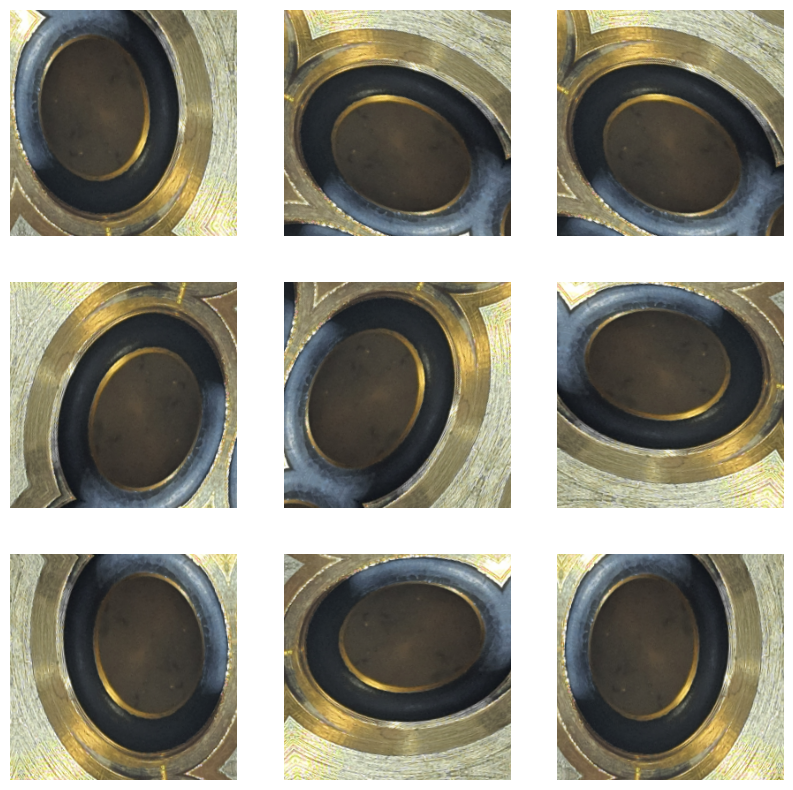

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
pre_processing_input = tf.keras.layers.Rescaling(1./255)

In [ ]:
base_model = tf.keras.models.Sequential([

#primeiro bloco
tf.keras.layers.Input(shape=(257, 257, 3)),
tf.keras.layers.Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), padding = "valid" , input_shape = (257,257,3),
                   activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2)),
tf.keras.layers.Dropout(0.25),

#segundo bloco
tf.keras.layers.Conv2D(filters = 256, kernel_size = (5,5), padding = "same", activation = "relu", kernel_regularizer =
                   tf.keras.regularizers.l2(0.0001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2)),
tf.keras.layers.Dropout(0.25),

#terceiro bloco
tf.keras.layers.Conv2D(filters = 384, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer =
                   tf.keras.regularizers.l2(0.0001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(filters = 384, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer =
                   tf.keras.regularizers.l2(0.0001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer =
                   tf.keras.regularizers.l2(0.0001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2)),
tf.keras.layers.Dropout(0.25),

#quarto bloco
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(units = 4096, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5),

#quinto bloco
tf.keras.layers.Dense(units = 4096, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5),

#sexto bloco
tf.keras.layers.Dense(units = 1)
])

In [ ]:
model = tf.keras.models.Sequential([
    data_augmentation,
    pre_processing_input,
    base_model
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 257, 257, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 257, 257, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 1)                 58323713  
                                                                 
Total params: 58323713 (222.49 MB)
Trainable params: 58304577 (222.41 MB)
Non-trainable params: 19136 (74.75 KB)
_________________________________________________________________


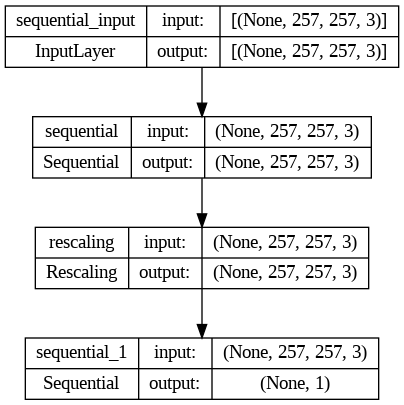

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
14/14 [==============================] - 49s 2s/step - loss: 1.3853 - accuracy: 0.8852 - precision: 0.8946 - recall: 0.8782 - val_loss: 1.9451 - val_accuracy: 0.4651 - val_precision: 0.4651 - val_recall: 1.0000
Epoch 2/20
14/14 [==============================] - 3s 199ms/step - loss: 1.1534 - accuracy: 0.9789 - precision: 0.9771 - recall: 0.9816 - val_loss: 1.8640 - val_accuracy: 0.4651 - val_precision: 0.4651 - val_recall: 1.0000
Epoch 3/20
14/14 [==============================] - 2s 145ms/step - loss: 1.1458 - accuracy: 0.9848 - precision: 0.9907 - recall: 0.9793 - val_loss: 1.8744 - val_accuracy: 0.4651 - val_precision: 0.4651 - val_recall: 1.0000
Epoch 4/20
14/14 [==============================] - 2s 145ms/step - loss: 1.1394 - accuracy: 0.9871 - precision: 0.9885 - recall: 0.9862 - val_loss: 1.7641 - val_accuracy: 0.8007 - val_precision: 0.7000 - val_recall: 1.0000
Epoch 5/20
14/14 [==============================] - 2s 146ms/step - loss: 1.1844 - accuracy: 0.9871 - prec

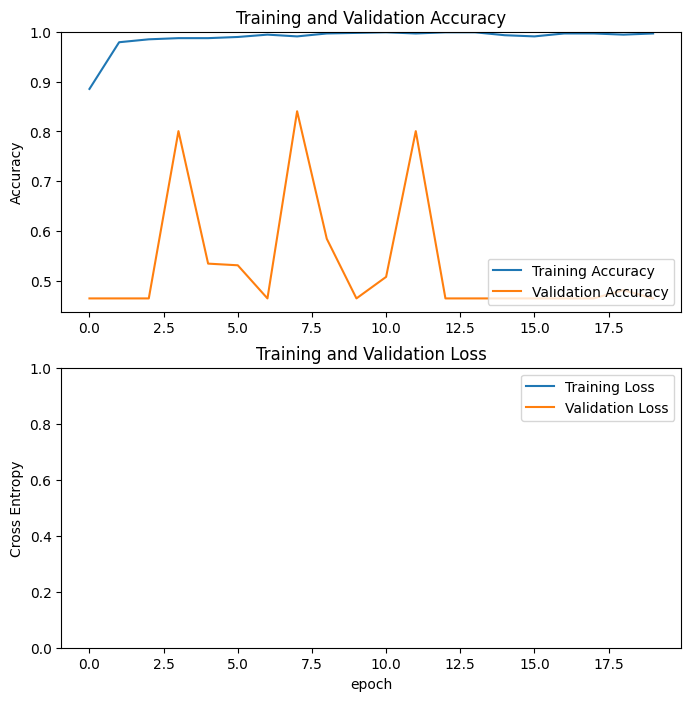

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print('Test precision :', precision)
print('Test recall :', recall)

1/1 [==============================] - 26s 26s/step - loss: 13.2411 - accuracy: 0.4062 - precision: 0.4062 - recall: 1.0000
Test accuracy : 0.40625
Test precision : 0.40625
Test recall : 1.0


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0
 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0]


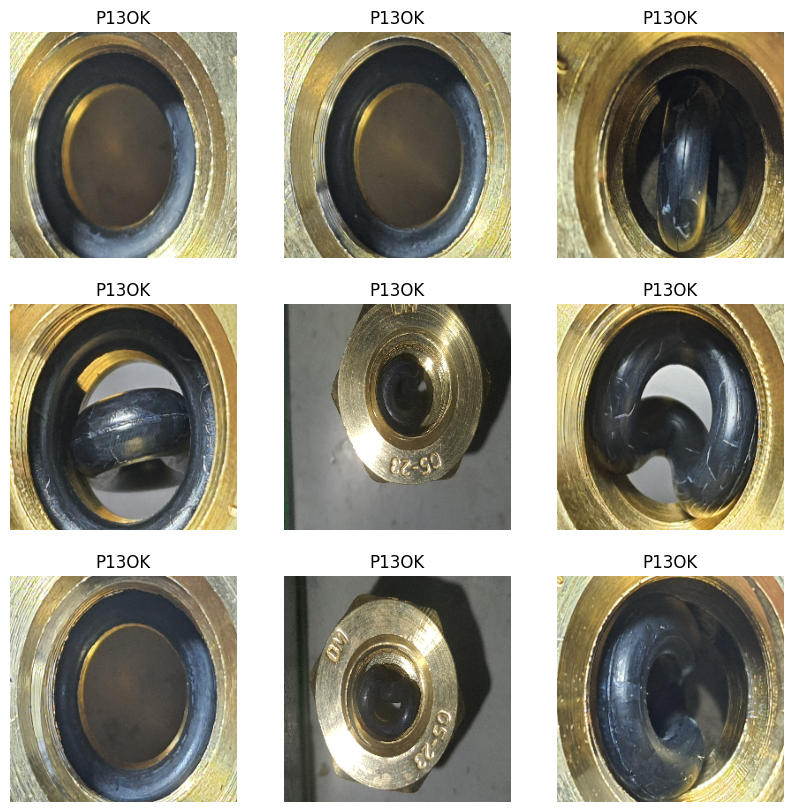

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model_json = model.to_json()
with open('network.json','w') as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(model, '/content/weights.hdf5')

<ipython-input-20-32bf80f9a744>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights.hdf5')
